# Librerías requeridas para el modelo de clasificación

In [67]:
# Librerías requeridas
import numpy as np
import pandas as pd
import tensorflow as tf
import os

# Separar la data.
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from PIL import Image

# Para la graficación
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

# Para el módelo y su entrenamiento
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

# Exploración del dataset

## Cargar metadatos para la exploración del dataset

In [33]:
# Path de los datos
inp_ds_path = 'GTSR/archive'

In [45]:
# Leer los nombreas de las clases
sign_names=pd.read_csv(inp_ds_path + '/sign_names.csv')
sign_names.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [35]:
# View Included CSV files
meta_df=pd.read_csv(inp_ds_path+'/Meta.csv')
meta_df.head()

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22


In [38]:
# Cargar el archivo CSV con las etiquetas del conjunto de prueba
y_test_csv = pd.read_csv(inp_ds_path + '/Test.csv')
y_test_csv.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [39]:
train_df=pd.read_csv(inp_ds_path+'/Train.csv')
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


## Graficar el histograma

In [58]:
# Crear un DataFrame para la distribución de datos en el conjunto de entrenamiento
data_distribution = pd.DataFrame(train_df['ClassId'].value_counts())
data_distribution = data_distribution.reset_index()

# Renombrar las columnas del DataFrame
data_distribution = data_distribution.rename(columns={'index':'ClassId'})

# Combinar los nombres de las señales con la distribución de datos por clase
data_distribution = data_distribution.merge(sign_names, how='inner', on='ClassId')

# Crear una columna combinada para el nombre de la señal y el ID de la clase
data_distribution['SignName_ClassId'] = data_distribution['SignName'] + ' [' + data_distribution['ClassId'].map(str) + ']'

C:\Users\famil\AppData\Local\Temp\ipykernel_15048\2072545129.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='SignName_ClassId', data=data_distribution, palette='viridis')


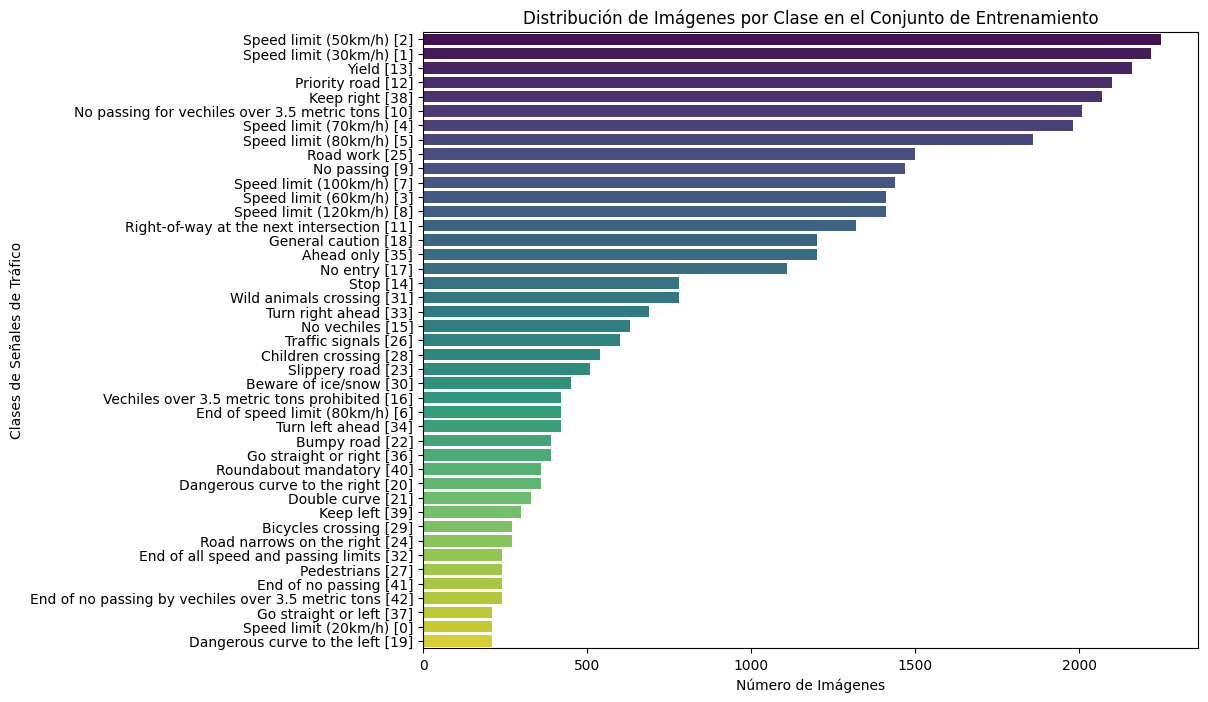

In [59]:
# Graficar el histograma utilizando seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x='count', y='SignName_ClassId', data=data_distribution, palette='viridis')
plt.title('Distribución de Imágenes por Clase en el Conjunto de Entrenamiento')
plt.xlabel('Número de Imágenes')
plt.ylabel('Clases de Señales de Tráfico')
plt.show()

## Visualizar las imágenes de las clases

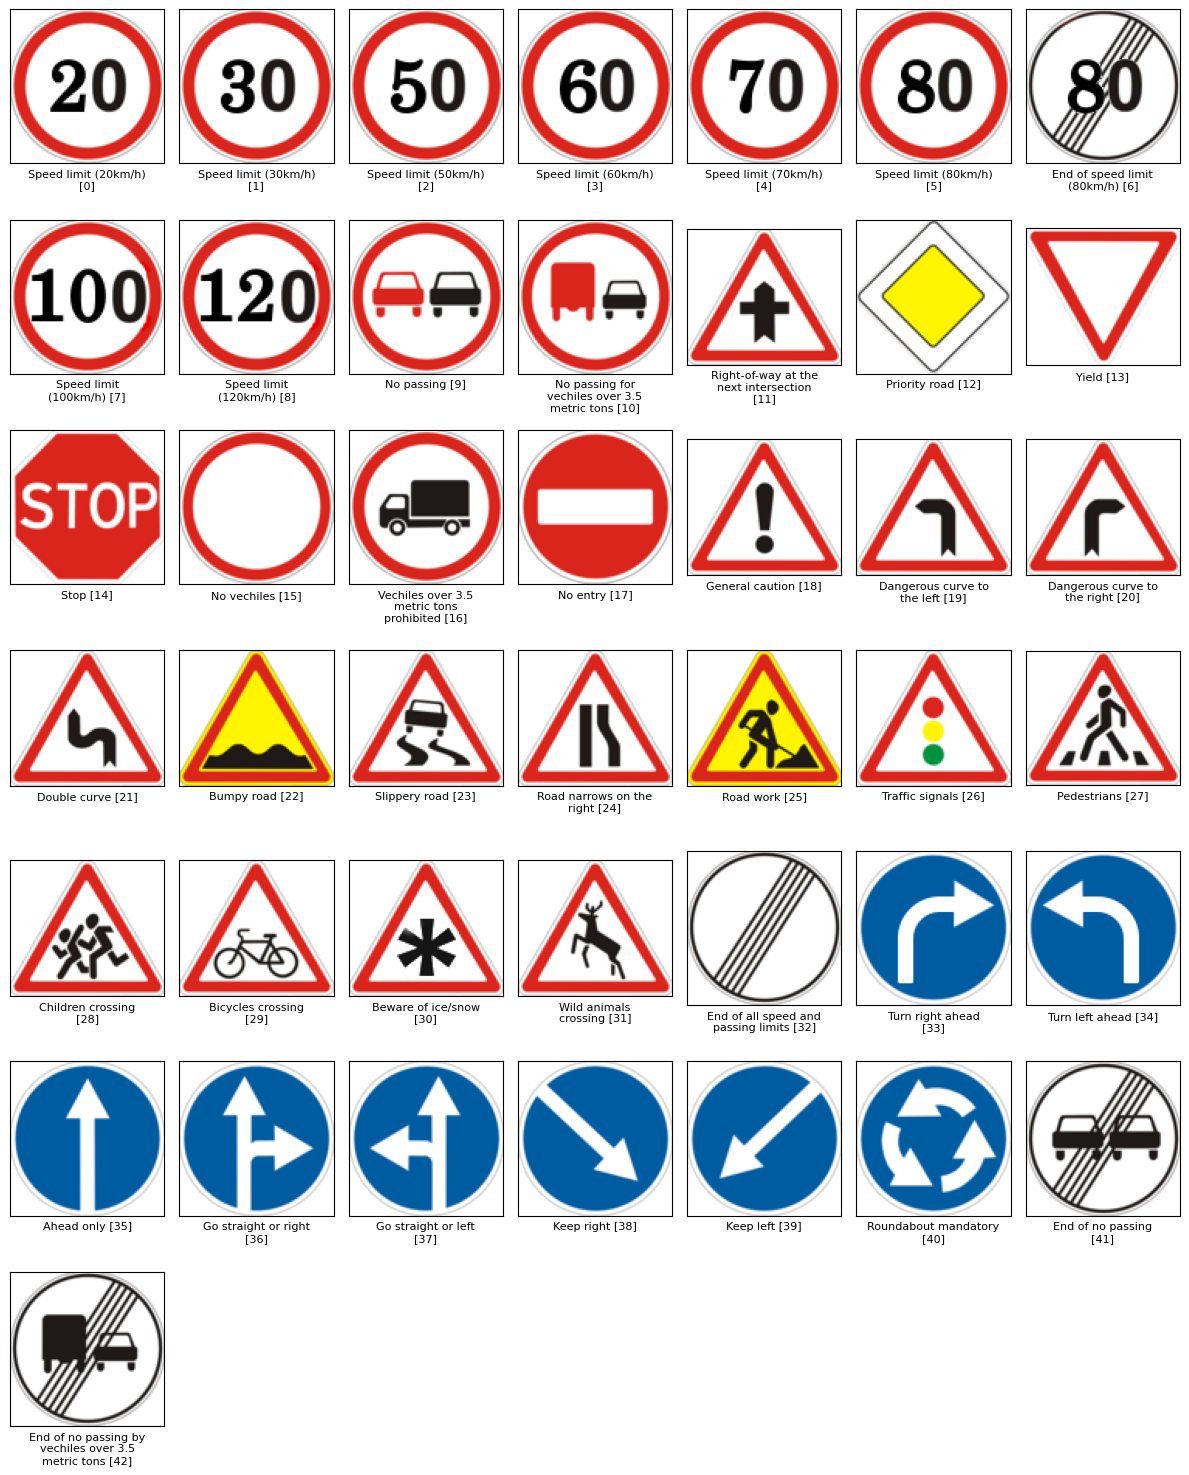

In [64]:
# Configurar el tamaño de la figura
plt.figure(figsize=(12, 15))

# Bucle para mostrar las imágenes de las 43 clases
for i in range(43):
    # Crear subgráficos: 7 filas por 7 columnas (máximo 49 gráficos, pero aquí son 43)
    plt.subplot(7, 7, i + 1)
    
    # Definir la ruta de la imagen según el número de clase
    temp_path = os.path.join(inp_ds_path, 'Meta', f'{i}.png') 
    im = Image.open(temp_path)  # Abrir la imagen de la clase actual
    
    # Mostrar la imagen
    plt.imshow(im)
    
    # Eliminar la cuadrícula a la imagen
    plt.grid(False)  
    
    # Obtener el nombre de la clase correspondiente desde el DataFrame
    s_name = data_distribution[data_distribution['ClassId'] == i]['SignName_ClassId'].values[0]
    
    # Ajustar el nombre de la clase para que se divida en líneas si es muy largo (máximo 20 caracteres por línea)
    s_name = '\n'.join(wrap(s_name, 20))
    
    # Remover los ticks (marcas) de los ejes X e Y para una mejor visualización
    plt.tick_params(
        axis='both',        # Aplicar cambios a ambos ejes (X e Y)
        which='both',       # Afectar tanto ticks mayores como menores
        bottom=False, top=False, labelbottom=False,  # Ocultar ticks en el eje X
        right=False, left=False, labelleft=False     # Ocultar ticks en el eje Y
    )
    
    # Añadir el nombre de la clase debajo de cada imagen
    plt.xlabel(s_name, fontsize=8)

# Mostrar la figura completa con las imágenes
plt.tight_layout()  # Ajustar el espaciado entre los subgráficos automáticamente para evitar solapamientos
plt.show()

# Cargar las imágenes

In [71]:
# Inicializamos las listas para almacenar los datos y las etiquetas
data = []
labels = []
classes = 43

# Ruta al directorio donde se encuentran las imágenes

# Ruta actual del notebook
cur_path = os.getcwd()  
# Ruta donde están las 43 clases
train_path = os.path.join(cur_path, 'GTSR', 'archive', 'Train')  

# Iteramos sobre cada una de las clases (43 directorios)
for i in range(classes):
    # Definir la ruta para la clase actual
    path = os.path.join(train_path, str(i))
    # Listar todas las imágenes dentro del directorio de la clase
    images = os.listdir(path)  

    # Iterar sobre cada imagen dentro de la clase
    for a in images:
        try:
            # Cargar la imagen
            image = Image.open(os.path.join(path, a))
            # Redimensionar la imagen a 30x30 píxeles
            image = image.resize((30, 30))
            # Convertir la imagen a un arreglo de NumPy
            image = np.array(image)
            # Añadir la imagen y la etiqueta a las listas
            data.append(image)
            labels.append(i)
        except Exception as e:
            print(f"Error al cargar la imagen {a}: {e}")

# Convertimos las listas a arreglos de NumPy
data = np.array(data)
labels = np.array(labels)

print(f"Total de imágenes cargadas: {len(data)}")
print(f"Total de etiquetas cargadas: {len(labels)}")

Total de imágenes cargadas: 39209
Total de etiquetas cargadas: 39209


# Verificar la carga de datos

In [72]:
# Revisar la forma (shape) de los datos y las etiquetas
print(data.shape, labels.shape)

# Dividir el dataset en conjuntos de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(data, labels,
                                                    test_size=0.2,
                                                    random_state=42)

# Mostrar la forma de los conjuntos tras la división
print(f"Forma de X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"Forma de y_train: {y_train.shape}, y_test: {y_test.shape}")

# Convertir las etiquetas en formato de codificación one-hot (43 clases)
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

# Revisar la nueva forma de las etiquetas tras la codificación one-hot
print(f"Forma de y_train (one-hot): {y_train.shape}, y_test (one-hot): {y_test.shape}")

(39209, 30, 30, 3) (39209,)
Forma de X_train: (31367, 30, 30, 3), X_test: (7842, 30, 30, 3)
Forma de y_train: (31367,), y_test: (7842,)
Forma de y_train (one-hot): (31367, 43), y_test (one-hot): (7842, 43)


# Compilación del modelo

In [73]:
# Construcción del modelo
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu',
                 input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

# Compilacion del modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Resumen del modelo
model.summary()

c:\Vision_Artificial\vision\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 22, 22, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 9, 9, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,251 (946.29 KB)

 Trainable params: 242,251 (946.29 KB)

 Non-trainable params: 0 (0.00 B)

# Entrenamiento del modelo

In [74]:
# Establecer el uso de la GPU
with tf.device('/GPU:0'):
    epochs = 15  # Número de épocas
    batch_size = 32  # Tamaño del lote

    # Entrenamiento del modelo
    history = model.fit(X_train, y_train, 
                        batch_size=batch_size, 
                        epochs=epochs, 
                        validation_data=(X_test, y_test))

Epoch 1/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 33s 31ms/step - accuracy: 0.0556 - loss: 4.4678 - val_accuracy: 0.2563 - val_loss: 2.9160
Epoch 2/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 31s 32ms/step - accuracy: 0.3516 - loss: 2.3762 - val_accuracy: 0.7876 - val_loss: 0.7373
Epoch 3/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 33s 34ms/step - accuracy: 0.7355 - loss: 0.8760 - val_accuracy: 0.9352 - val_loss: 0.2321
Epoch 4/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 31s 32ms/step - accuracy: 0.8389 - loss: 0.5252 - val_accuracy: 0.9461 - val_loss: 0.1758
Epoch 5/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 30s 30ms/step - accuracy: 0.8795 - loss: 0.4006 - val_accuracy: 0.9528 - val_loss: 0.1689
Epoch 6/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - accuracy: 0.8917 - loss: 0.3586 - val_accuracy: 0.9638 - val_loss: 0.1158
Epoch 7/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - accuracy: 0.8991 - loss: 0.3483 - val_accuracy: 0.9569 - val_loss: 0.1440
Epoch 8/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 35s 35ms/step - accuracy: 0.9099 - loss: 0.3036 - 

# Gráficas del Accuray y Loss

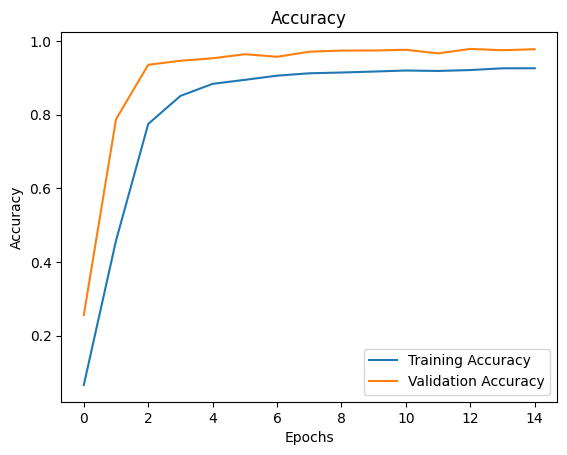

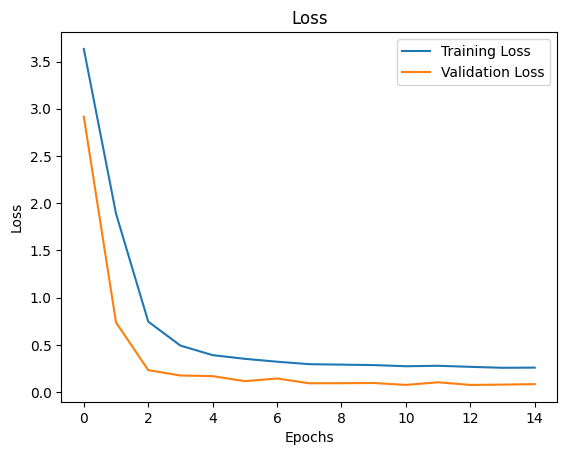

In [75]:
# Gráfico de la precisión (accuracy)
plt.figure(0)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Gráfico de la pérdida (loss)
plt.figure(1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Validación del modelo con los datos de *Test*

In [76]:
# Extraer las etiquetas (ClassId) y las rutas de las imágenes
labels = y_test_csv["ClassId"].values
imgs = y_test_csv["Path"].values

# Inicializar lista para las imágenes
data = []

# Leer las imágenes del directorio de prueba
with tf.device('/GPU:0'):
    for img_path in imgs:
        image = Image.open('GTSR/archive/' + img_path)
        # Redimensionar a 30x30 como en el conjunto de entrenamiento
        image = image.resize([30, 30])  
        data.append(np.array(image))

# Convertir las imágenes y etiquetas en arrays numpy
X_test = np.array(data)
y_test_labels = np.array(labels)

# Convertir las etiquetas a one-hot encoding (como en el entrenamiento)
y_test = tf.keras.utils.to_categorical(y_test_labels, num_classes=43)

# Evaluar el modelo en el conjunto de prueba
with tf.device('/GPU:0'):
    test_loss, test_acc = model.evaluate(X_test, y_test)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

395/395 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9389 - loss: 0.2693
Test Accuracy: 0.9390
Test Loss: 0.2745


# Guardar el modelo

In [77]:
model.save('classifier_GTSR_CNN.h5')

# Cargar el modelo para el análisis de resultados

395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


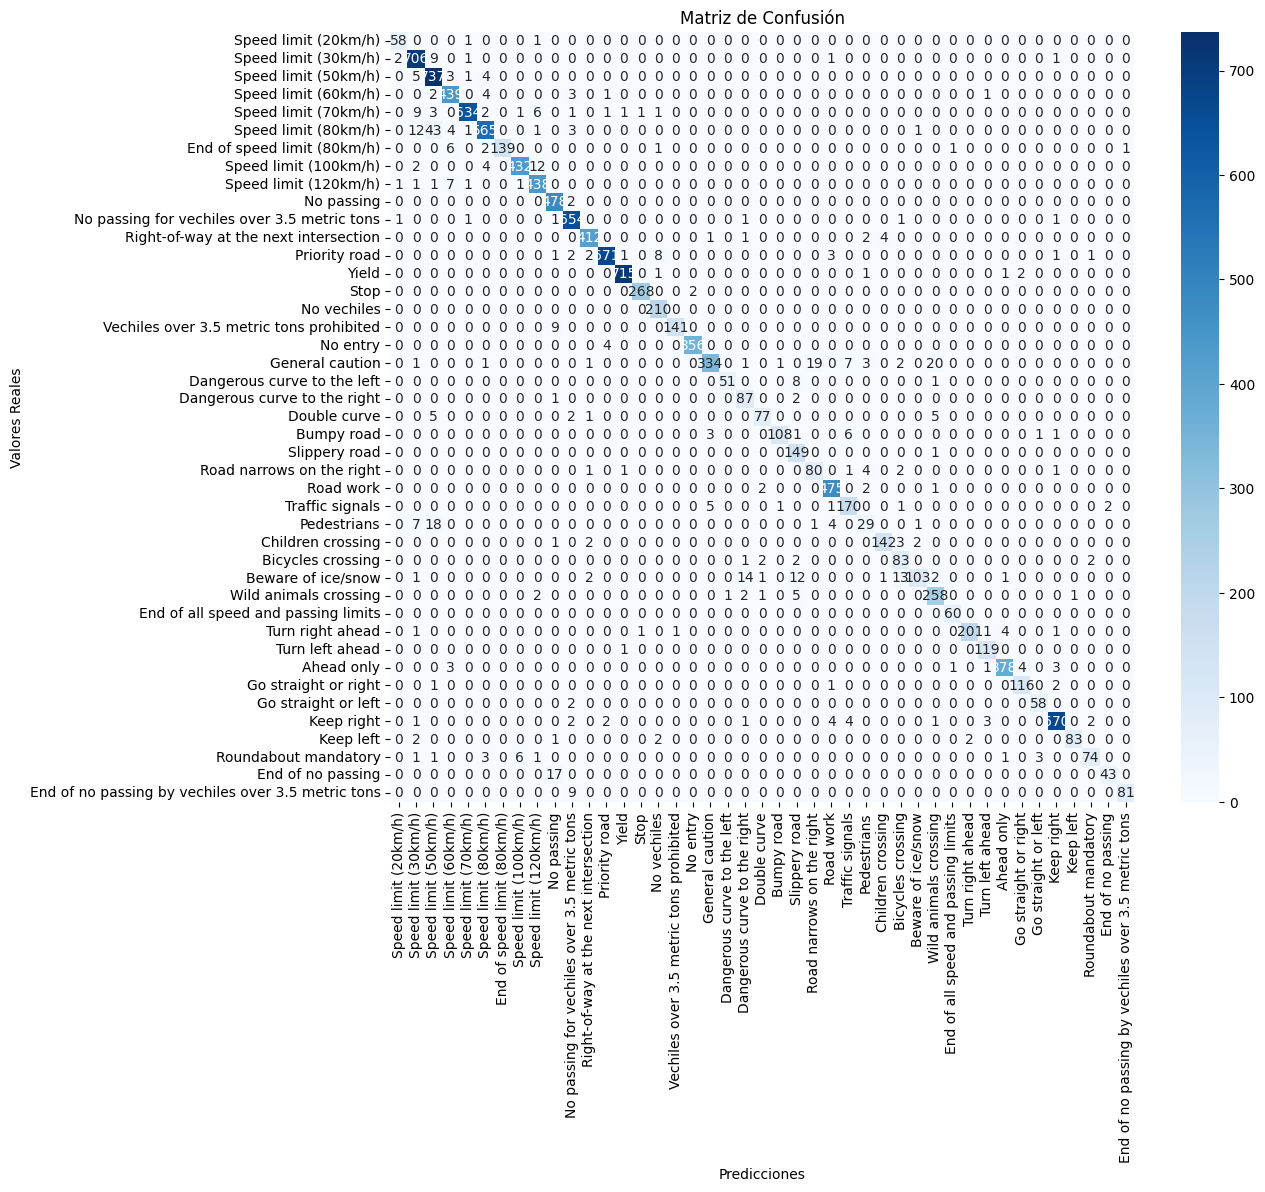

In [78]:
# Cargar el modelo guardado
model = load_model('classifier_GTSR.h5')

# Realizar predicciones sobre el conjunto de test
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Obtener la clase con la mayor probabilidad

# Convertir las etiquetas de test (one-hot encoded) a su formato original (clase)
y_true = np.argmax(y_test, axis=1)

# Generar la matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)

# Graficar la matriz de confusión
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sign_names['SignName'], yticklabels=sign_names['SignName'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()